# Example use of prototype Optimal Predictor Machine with income-dataset

Load required libraries and functions

In [1]:
library('data.table')
library('extraDistr')
library('foreach')
library('png')
source('tplotfunctions.R')
source('guessmetadata.R')
source('buildagent.R')
source('infer.R')
source('decide.R')
source('mutualinfo.R')
source('rF.R')
source('plotFsamples1D.R')
options(repr.plot.width=10*sqrt(2), repr.plot.height=10)

## Creation of preliminary metadata file

is done with `guessmetadata()` applied to a (cleaned, ready) set of training data.

You can then alter the file by hand, for example adding values that you know are in principle possible (even if unseen in the training data). Remember to adjust the `domainsize` column in that case!

In [2]:
guessmetadata(data='train-income_data_example.csv',
              file='preliminary.csv')

The actual metadata file for the present exploration is ready in `meta_income_data_example.csv`:

In [3]:
print(fread('meta_income_data_example.csv', header=TRUE))

          variate domainsize                 V1                 V2                 V3
1:      workclass          7        Federal-gov          Local-gov            Private
2:      education         16               10th               11th               12th
3: marital_status          7           Divorced  Married-AF-spouse Married-civ-spouse
4:     occupation         14       Adm-clerical       Armed-Forces       Craft-repair
5:   relationship          6            Husband      Not-in-family     Other-relative
6:           race          5 Amer-Indian-Eskimo Asian-Pac-Islander              Black
7:            sex          2             Female               Male                   
8: native_country         42           Cambodia             Canada              China
9:         income          2              <=50K               >50K                   
                      V4               V5                 V6                V7
1:          Self-emp-inc Self-emp-not-inc          State-gov 

## Building the agent

is done with the function `buildagent()`, which takes as input the metadata and training data, and output an object of class "agent".

In this exploration we build two agents:
- `opm10`: trained with 10 datapoints
- `opmall`: trained with all datapoints

In [4]:
opm10 <- buildagent(metadata='meta_income_data_example.csv',
                    data=fread('train-income_data_example.csv', header=TRUE)[1:10])

opmall <- buildagent(metadata='meta_income_data_example.csv',
                     data='train-income_data_example.csv')

You can check the internal structure of the "agent" object with `str()`:

In [5]:
str(opmall)

List of 4
 $ counts   : num [1:7, 1:16, 1:7, 1:14, 1:6, 1:5, 1:2, 1:42, 1:2] 0 0 0 0 0 0 0 0 0 0 ...
  ..- attr(*, "dimnames")=List of 9
  .. ..$ workclass     : chr [1:7] "Federal-gov" "Local-gov" "Private" "Self-emp-inc" ...
  .. ..$ education     : chr [1:16] "10th" "11th" "12th" "1st-4th" ...
  .. ..$ marital_status: chr [1:7] "Divorced" "Married-AF-spouse" "Married-civ-spouse" "Married-spouse-absent" ...
  .. ..$ occupation    : chr [1:14] "Adm-clerical" "Armed-Forces" "Craft-repair" "Exec-managerial" ...
  .. ..$ relationship  : chr [1:6] "Husband" "Not-in-family" "Other-relative" "Own-child" ...
  .. ..$ race          : chr [1:5] "Amer-Indian-Eskimo" "Asian-Pac-Islander" "Black" "Other" ...
  .. ..$ sex           : chr [1:2] "Female" "Male"
  .. ..$ native_country: chr [1:42] "Cambodia" "Canada" "China" "Columbia" ...
  .. ..$ income        : chr [1:2] "<=50K" ">50K"
 $ alphas   : num [1:21] 1 2 4 8 16 32 64 128 256 512 ...
 $ auxalphas: num [1:21] -160706 -157643 -154588 -15154

The "agent" object internally contains a parameter `alpha` expressing its guess of how many training data (just as a order of magnitude in base-2) would be needed to make reliable inferences about the full population.

Here are several guesses with their probabilities; you see that most probable is around 2000 training datapoints:

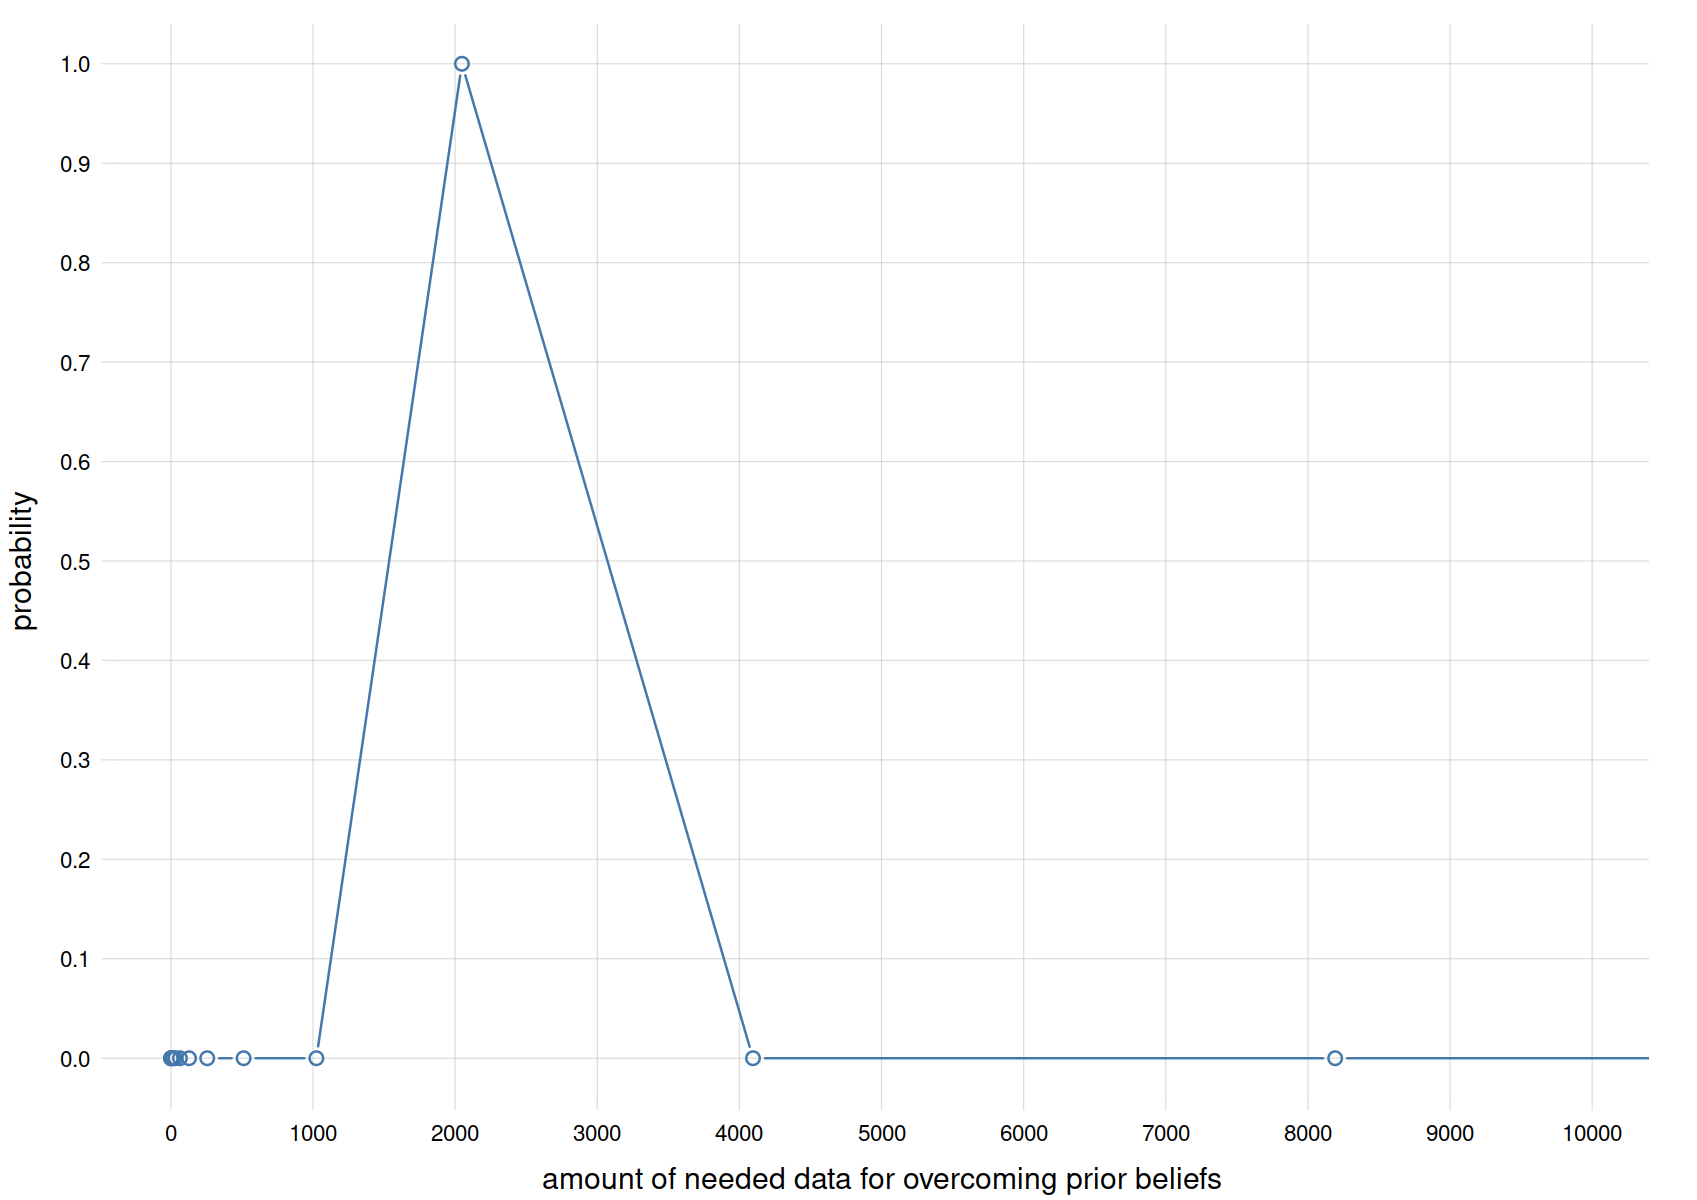

In [6]:
tplot(x=opmall$alphas, y=opmall$palphas, type='b',
      xlim=c(0, 10000), ylim=c(0, NA),
      xlab='amount of needed data for overcoming prior beliefs', ylab='probability')


# Example applications

## Only predictands, no predictors ("unsupervised-learning mode")

Let the little-trained agent forecast `income` for next unit

In [7]:
print(infer(agent=opm10, predictand='income'))

income
   <=50K     >50K 
0.506288 0.493712 


The agent is internally checking *all possible* population-frequency distributions. It can therefore forecast how its probabilities could change *if more training data were provided*:

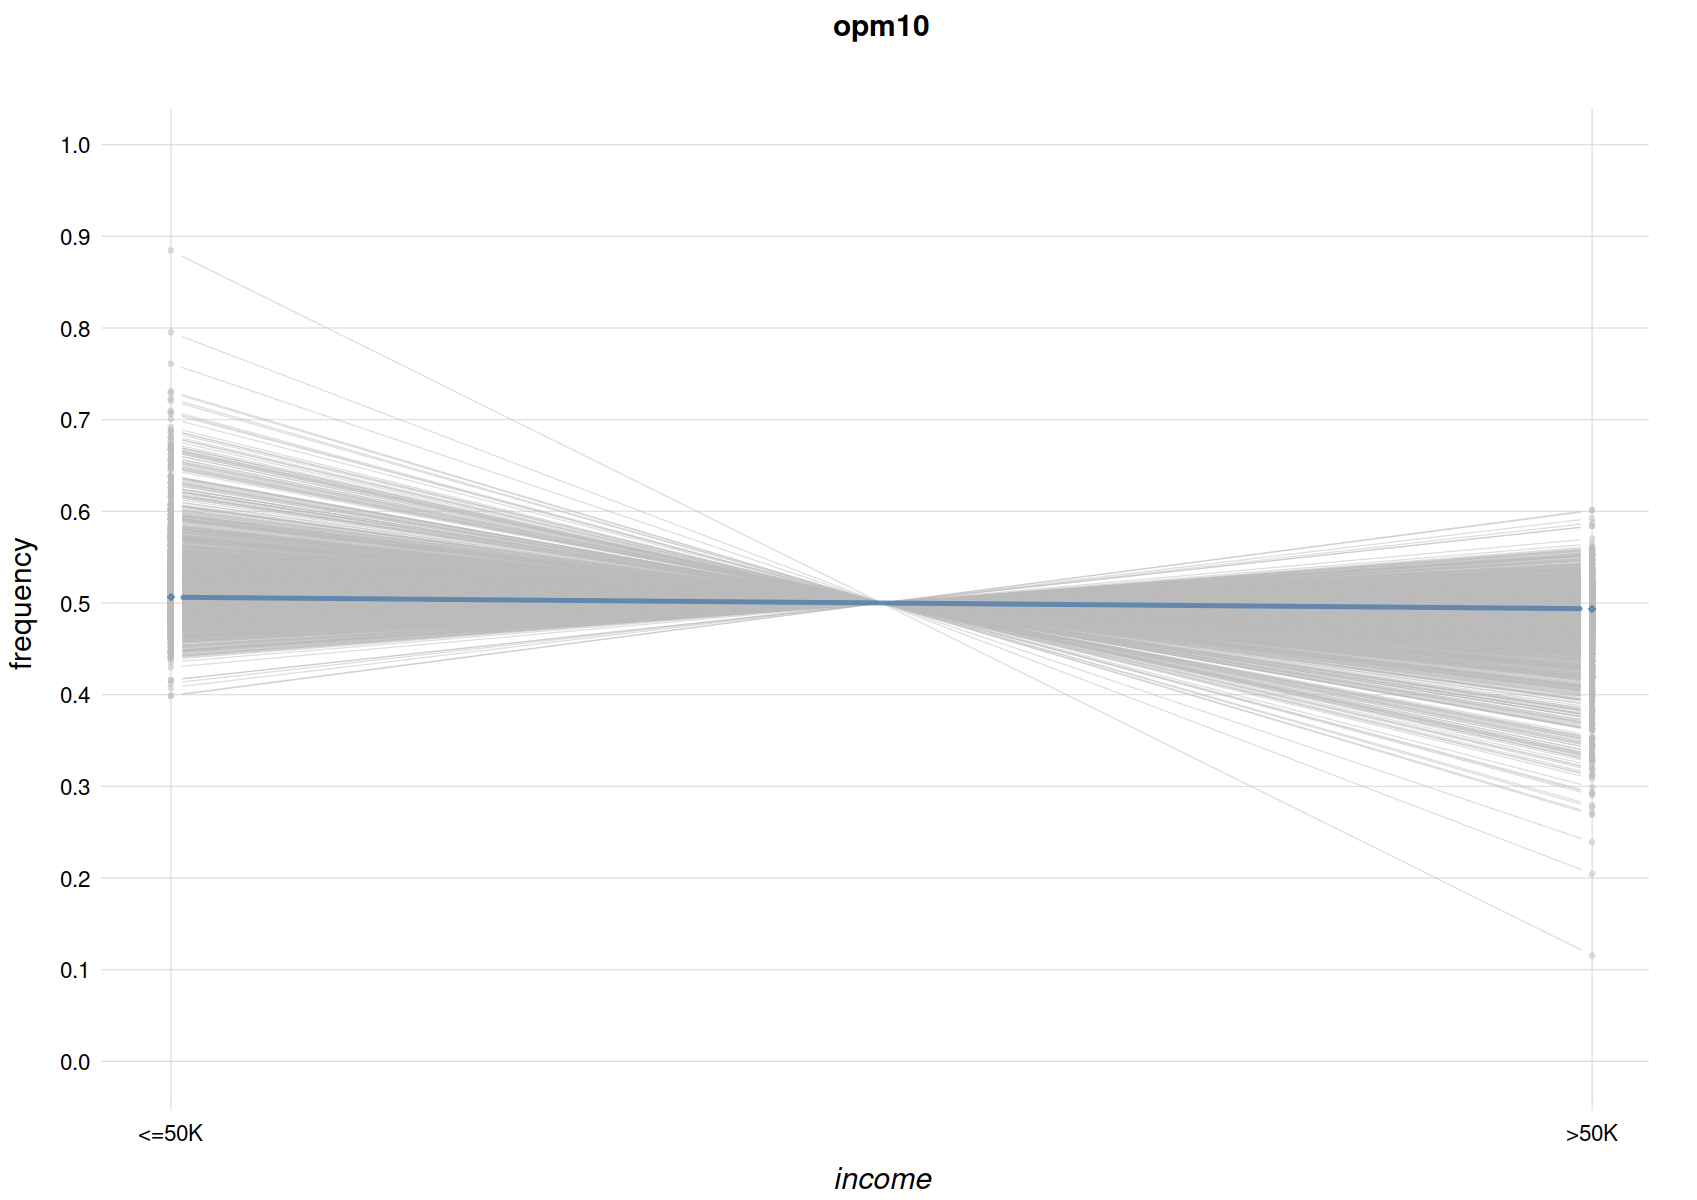

In [10]:
plotFsamples1D(agent=opm10, n=5000, predictand='income',
               ylim=c(0,1), main='opm10') # last options are for plotting

Now let's check the inference drawn by the fully-trained agent

In [9]:
print(infer(agent=opmall, predictand='income'))

income
   <=50K     >50K 
0.714318 0.285682 


Also this agent can tell us how much would new training data change its inference:

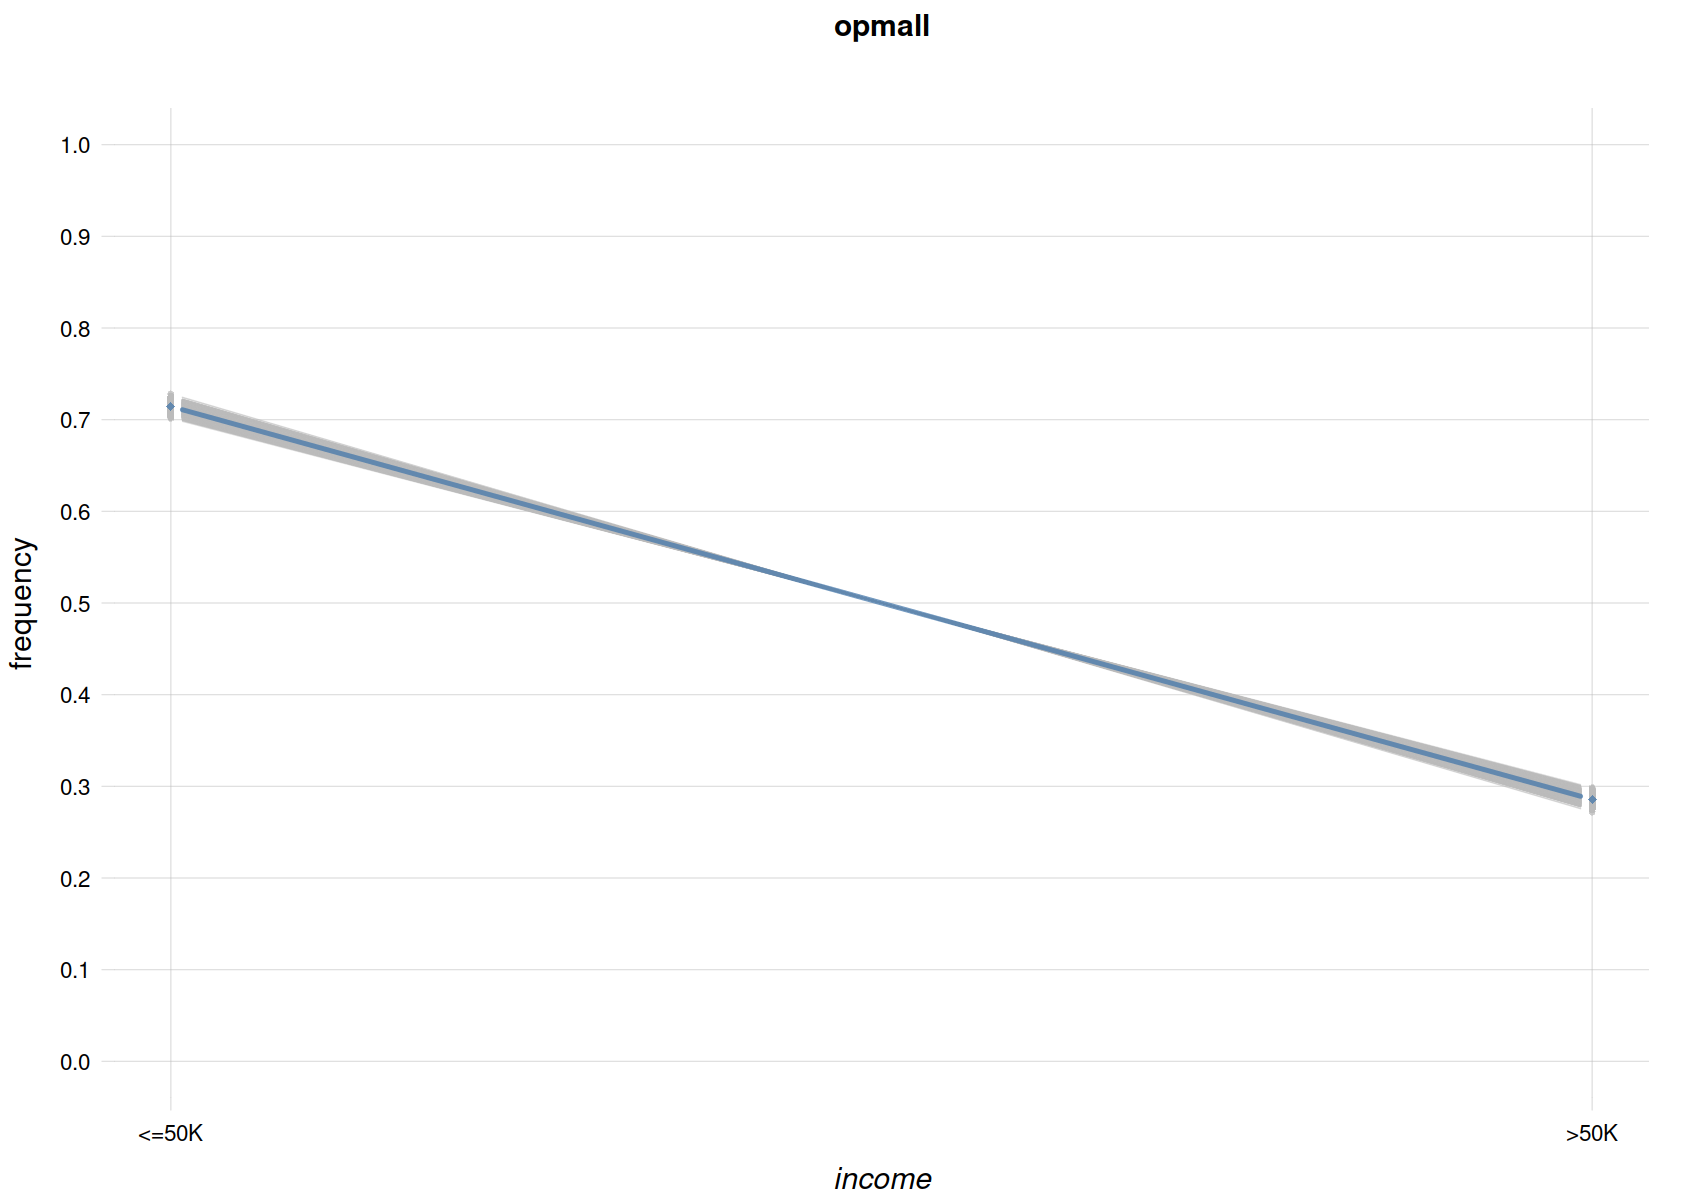

In [11]:
plotFsamples1D(agent=opmall, n=5000, predictand='income',
               ylim=c(0,1), main='opmall')

We can draw inferences in the same way for any other variate, e.g. `race`.

This is the inference by the `opm10` agent:

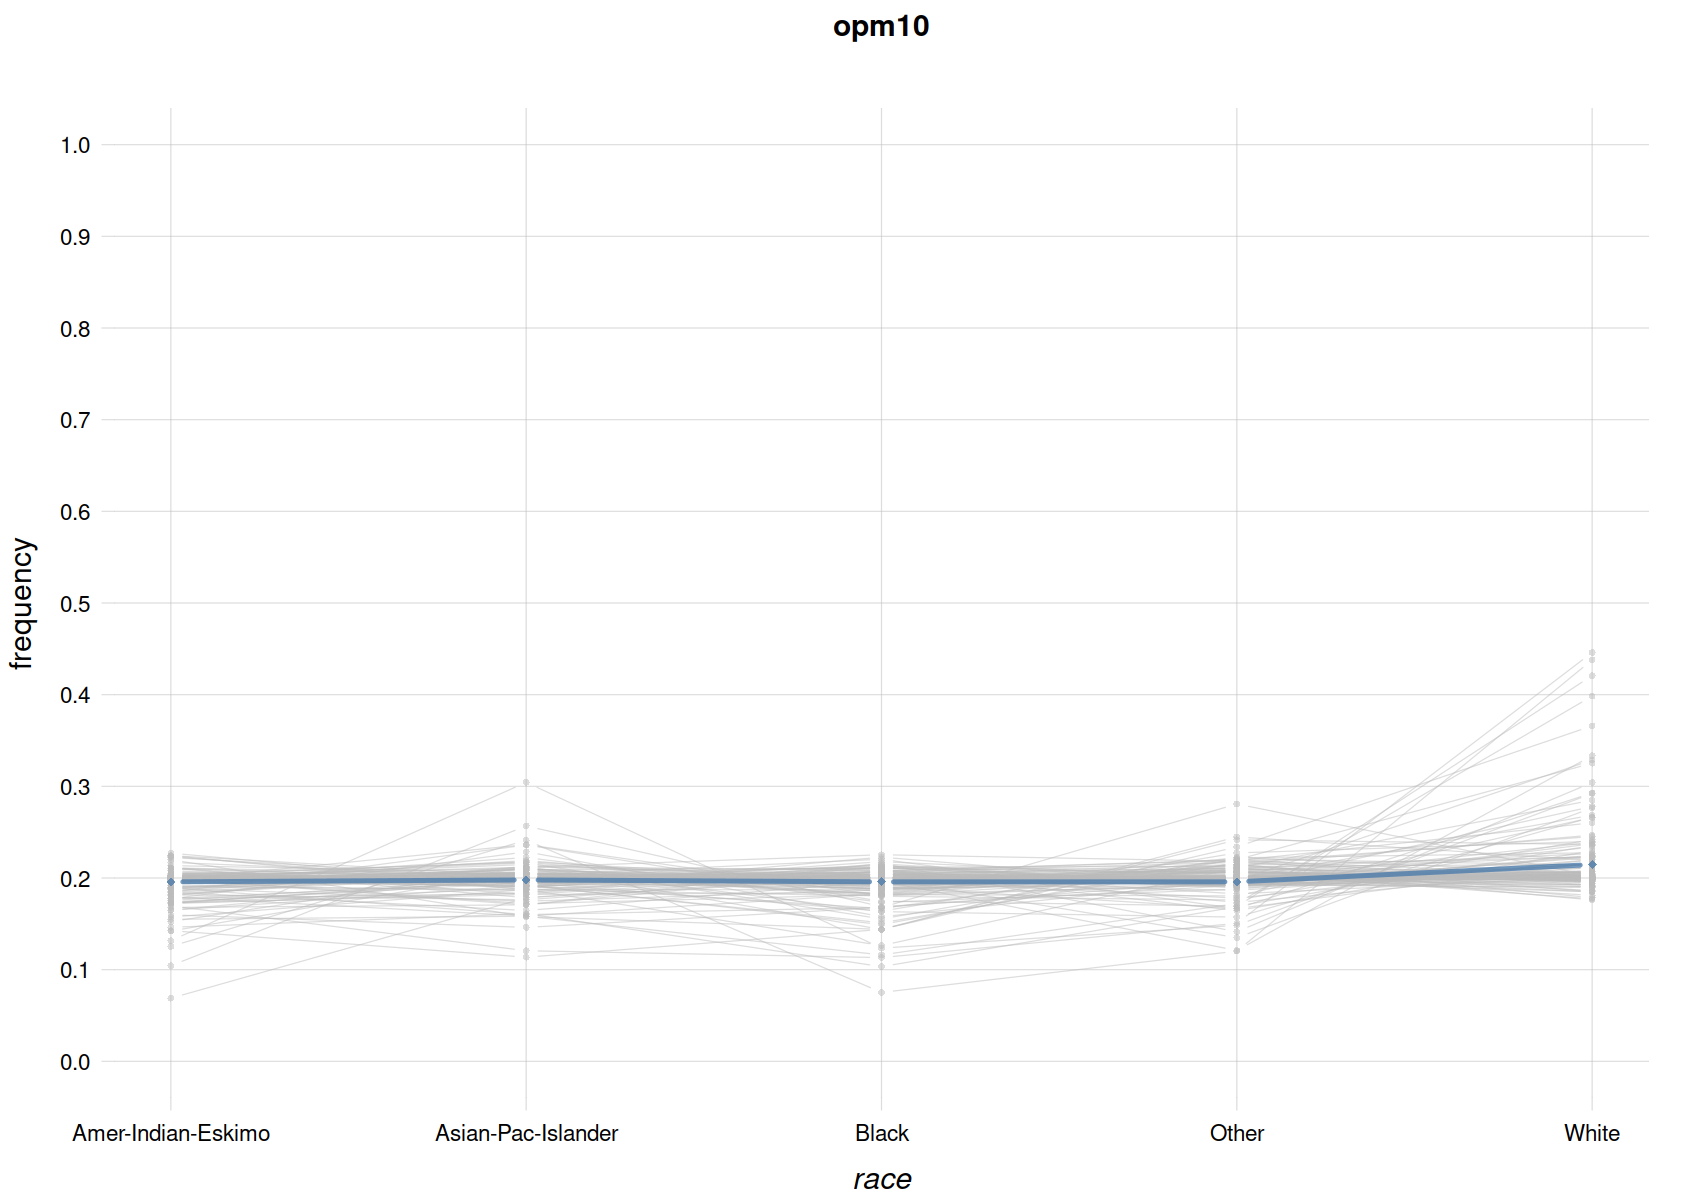

In [11]:
plotFsamples1D(agent=opm10, n=200, predictand='race',
               ylim=c(0,1), main='opm10')  # last options are for plotting

...and by the `opmall` agent:

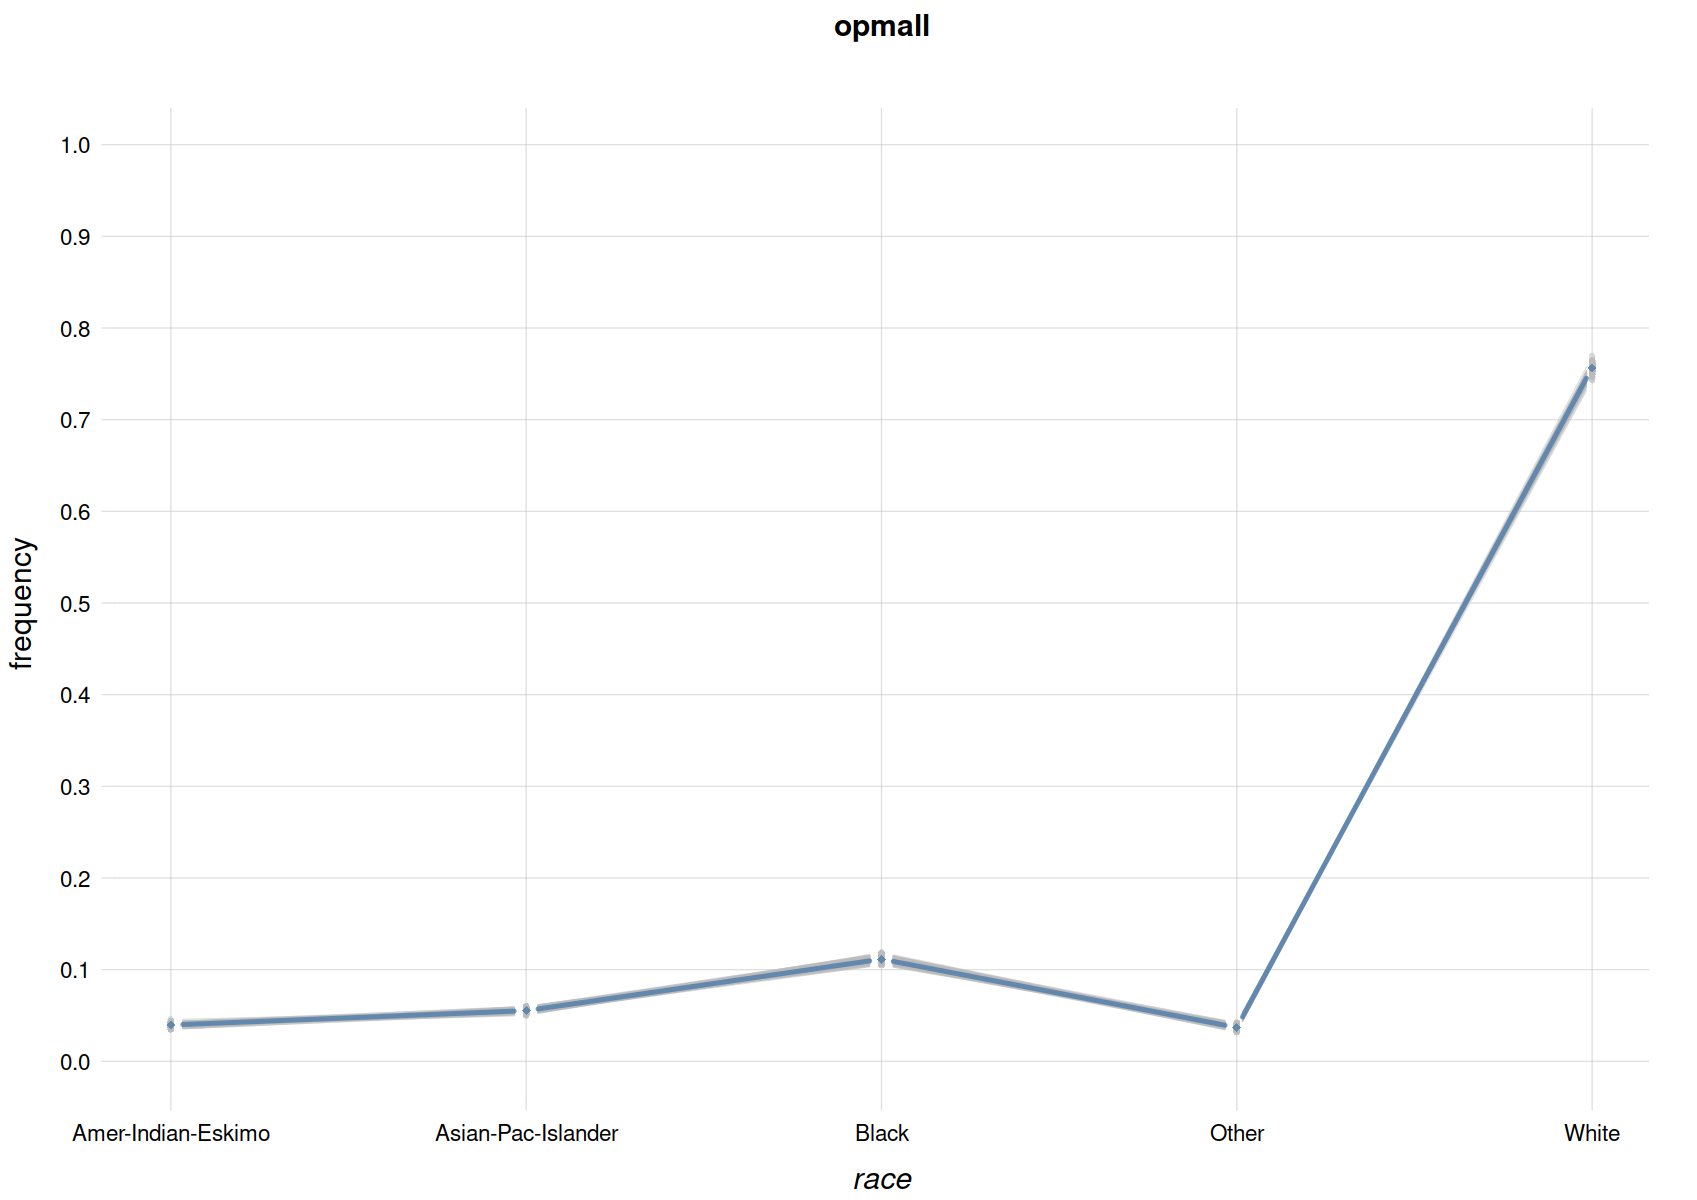

In [12]:
plotFsamples1D(agent=opmall, n=200, predictand='race',
               ylim=c(0,1), main='opmall')  # last options are for plotting

The agent can also draw inferences about several joint variates.

For instance `race` and `income` (let's show percentages and round to one decimal):

In [13]:
result <- infer(agent=opmall, predictand=c('race', 'income'))

print(round(result*100, 1))

                    income
race                 <=50K >50K
  Amer-Indian-Eskimo   2.3  1.6
  Asian-Pac-Islander   3.4  2.2
  Black                8.5  2.6
  Other                2.1  1.6
  White               55.2 20.5



## Using predictors ("supervised-learning mode")

Suppose we know that `occupation='Exec-managerial'` and `race='Black'` for the new unit. What can the `income` be?

In [15]:
result <- infer(agent=opmall, predictand='income',
               predictor=list(occupation='Exec-managerial', race='Black'))

print(round(result*100, 1))

income
<=50K  >50K 
 57.7  42.3 


Also in this case we can ask how much this inference could be changed by new training data.

Note how the agent warns us that, with more training data, it could happen that the percentages would be reversed – observe the gray lines:

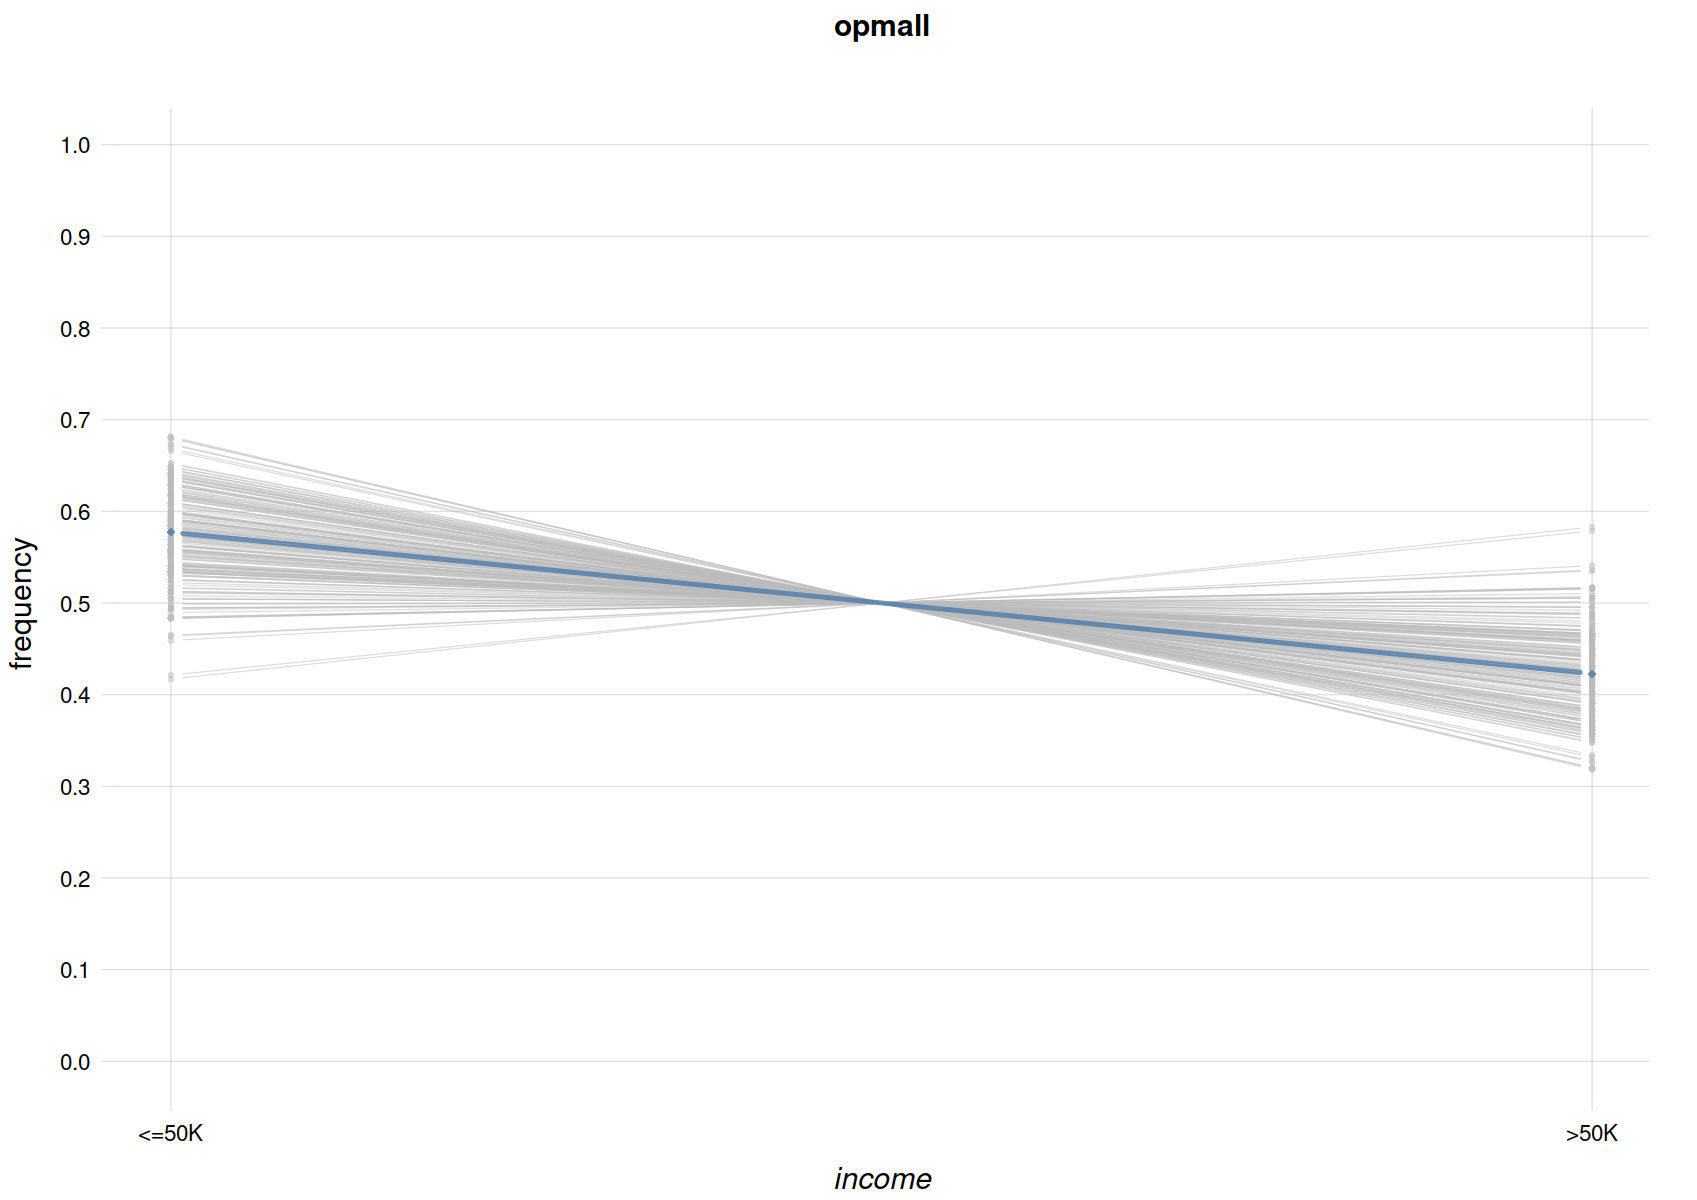

In [17]:
plotFsamples1D(agent=opmall, n=200,
               predictand='income',
               predictor=list(occupation='Exec-managerial', race='Black'),
               ylim=c(0,1), main='opmall')

Another example: what's the probability for the possible `occupation`, if we know the present person is `Black` and `Female`?

occupation
    Other-service      Adm-clerical    Prof-specialty             Sales 
             21.4              18.8               9.7               9.7 
Machine-op-inspct   Exec-managerial      Tech-support Handlers-cleaners 
              8.8               6.9               4.2               3.9 
  Priv-house-serv      Craft-repair   Protective-serv  Transport-moving 
              3.4               3.2               3.1               2.7 
  Farming-fishing      Armed-Forces 
              2.3               2.0 


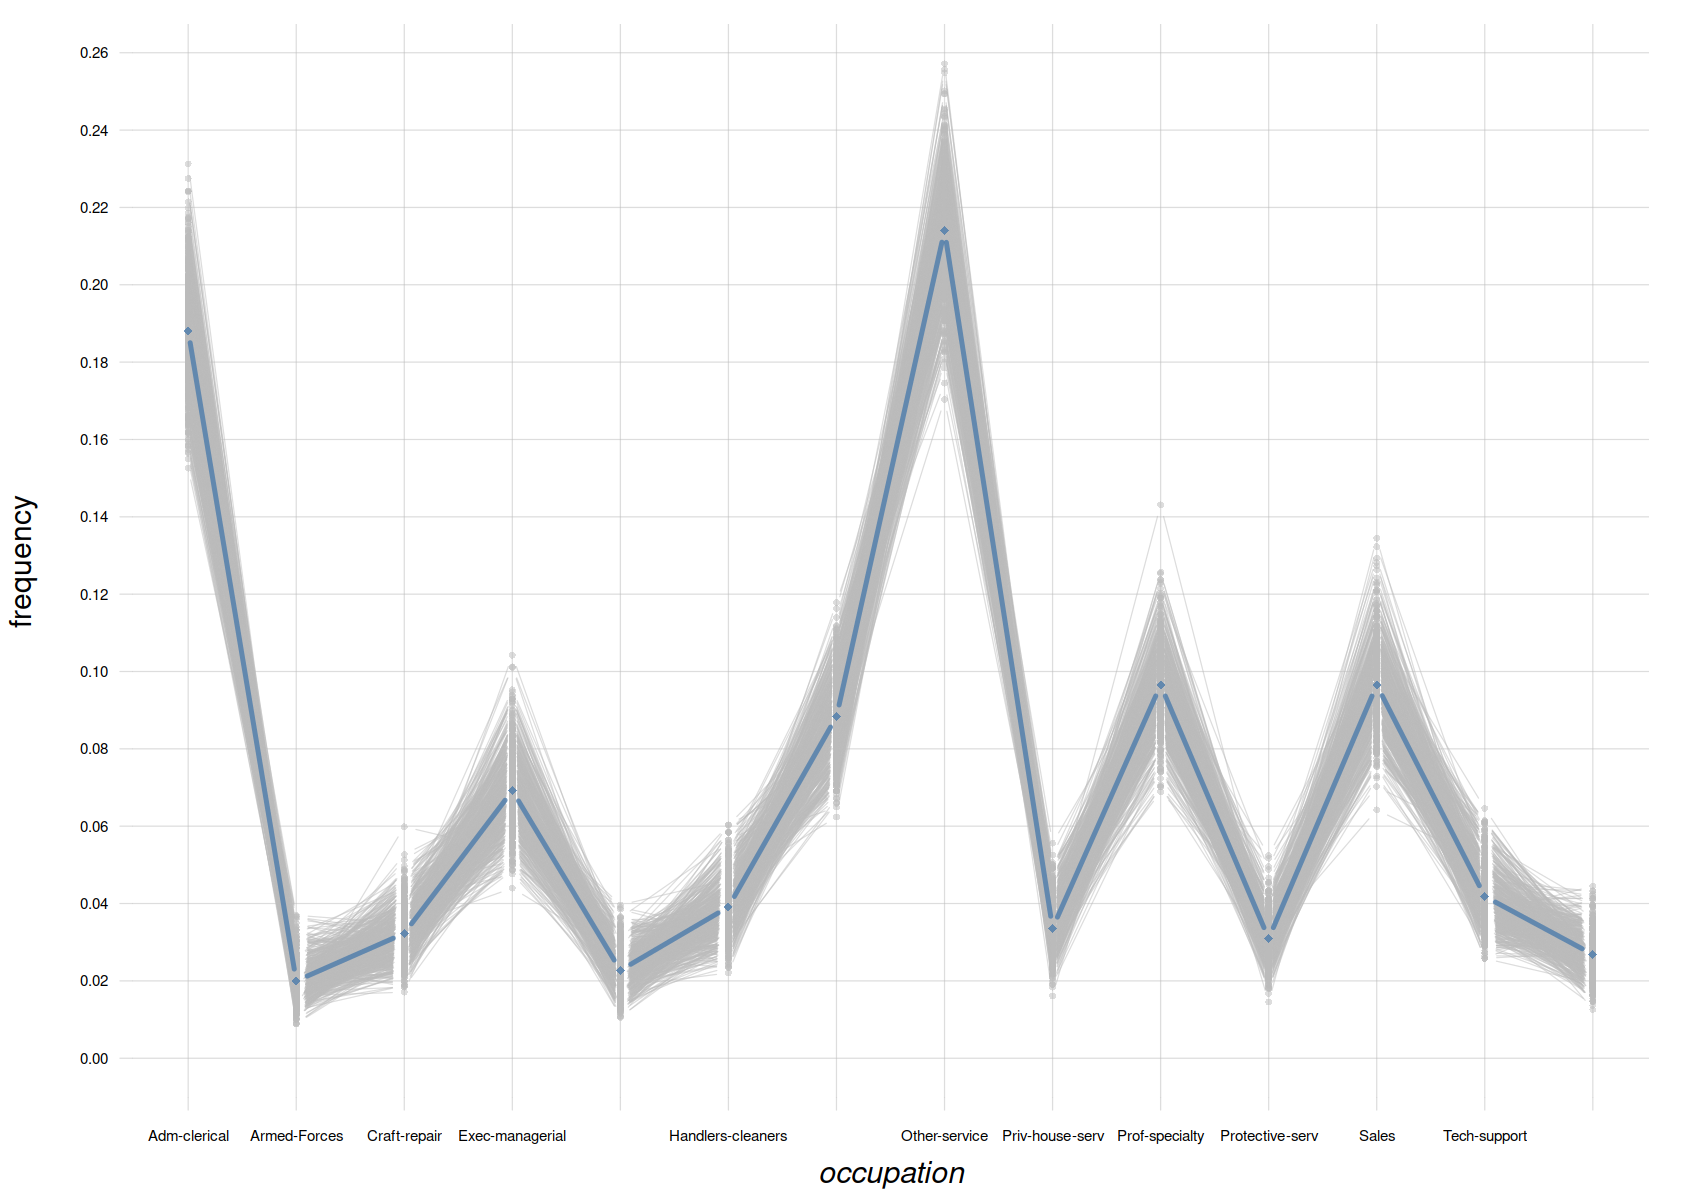

In [19]:
result <- infer(agent=opmall,
                predictand='occupation',
                predictor=list(race='Black', sex='Female'))

print(round(sort(result, decreasing=TRUE) * 100, 1))

plotFsamples1D(agent=opmall, n=500,
               predictand='occupation',
               predictor=list(race='Black', sex='Female'),
              ylim=c(0,NA), cex.axis=0.75)

## Inverting predictors and predictands ("generative mode")

We can also infer `occupation` and `sex` given any value of `income`

In [29]:
result <- infer(agent=opmall, predictand=c('occupation', 'sex'),
                predictor=list(income='<=50K'))

print('income == <=50K')
print(round(result * 100, 2))

cat('\n\n') # some newlines


result <- infer(agent=opmall, predictand=c('occupation', 'sex'),
                predictor=list(income='>50K'))

print('income == >50K')
print(round(result * 100, 2))

[1] "income == <=50K"
                   sex
occupation          Female  Male
  Adm-clerical        9.40  3.77
  Armed-Forces        0.38  0.39
  Craft-repair        1.06 11.80
  Exec-managerial     3.99  5.05
  Farming-fishing     0.56  3.49
  Handlers-cleaners   1.11  4.98
  Machine-op-inspct   2.30  5.04
  Other-service       6.77  5.65
  Priv-house-serv     0.95  0.43
  Prof-specialty      4.64  4.74
  Protective-serv     0.69  2.07
  Sales               5.23  6.36
  Tech-support        1.65  1.71
  Transport-moving    0.69  5.11


[1] "income == >50K"
                   sex
occupation          Female  Male
  Adm-clerical        3.13  4.10
  Armed-Forces        0.96  1.01
  Craft-repair        1.09  9.40
  Exec-managerial     3.61 16.00
  Farming-fishing     0.98  2.11
  Handlers-cleaners   1.01  1.59
  Machine-op-inspct   1.12  3.13
  Other-service       1.56  1.85
  Priv-house-serv     0.98  0.96
  Prof-specialty      4.79 14.75
  Protective-serv     1.04  3.21
  Sales           

----

## The `rF()` function

This function generates **full-population** frequency distributions (even for subpopulations) that are probable according to the data.

For instance, let's see three samples of how the full-population frequency distribution for `sex` and `income` (jointly) could be:

In [65]:
result <- rF(agent=opmall, n=3, predictand=c('sex', 'income'))

print(aperm(result) * 100) # permutation so that the samples are the last array dimension

, , 1

       sex
income    Female    Male
  <=50K 28.58493 43.0869
  >50K   6.88782 21.4403

, , 2

       sex
income    Female    Male
  <=50K 28.07293 43.5313
  >50K   6.72165 21.6741

, , 3

       sex
income    Female    Male
  <=50K 27.79377 43.2523
  >50K   7.14477 21.8092



These possible full-population frequency distributions can be used to assess how much the probabilities we find could change, if we collected a much, much larger amount of training data.

In the example below, we generate 1000 frequency distributions for `occupation` & `sex` given `income == >50K`, and then take the standard deviations of the samples as a rough measure of how much the probabilities we calculated a couple of cells above could change:

In [35]:
freqsamples <- rF(n=1000, agent=opmall, predictand=c('occupation', 'sex'),
                  predictor=list(income='>50K'))

variability <- apply(freqsamples,
                     c('occupation','sex'), # which dimensions to apply
                     sd) # function to apply to those dimensions

print(round(variability * 100, 2)) # round to two decimals

                   sex
occupation          Female Male
  Adm-clerical        0.29 0.33
  Armed-Forces        0.16 0.16
  Craft-repair        0.17 0.48
  Exec-managerial     0.31 0.59
  Farming-fishing     0.15 0.23
  Handlers-cleaners   0.16 0.20
  Machine-op-inspct   0.16 0.29
  Other-service       0.20 0.22
  Priv-house-serv     0.16 0.15
  Prof-specialty      0.34 0.58
  Protective-serv     0.16 0.29
  Sales               0.22 0.49
  Tech-support        0.19 0.29
  Transport-moving    0.16 0.31


----

## Calculating relevance of predictors

The agent can calculate the mutual information (measured in shannons) between any two sets of variates `A` and `B` of our choice, with the function `mutualinfo(probs, A, B)`. The joint probabilities for `(A,B)` must first be calculated with `infer()`.

For instance, what is the mutual information between `occupation` and `marital status`? The mutual information in this case can be anywhere between 0 Sh and 1 Sh 

(We print the result with 4 significant digits)

In [38]:
probs <- infer(agent=opmall, predictand=c('income', 'race', 'sex'))

result <- mutualinfo(probs=probs, A='income', B=c('race','sex'))

print(paste0(signif(result, 4), ' Sh'))

[1] "0.02952 Sh"


Let’s consider a scenario where, in order to save resources, we can use *only one* variate in order to infer the income. Which of the other variates should we prefer?

We can calculate the mutual information between each of them and `income`:

In [39]:
## list of all variates
variates <- names(dimnames(opmall$counts))

## list of all variates except 'income'
predictors <- variates[variates != 'income']

## prepare vector to contain the mutual information between each of these possible variates and 'income'
relevances <- numeric(length(predictors))
names(relevances) <- predictors

## calculate joint probability and then mutual information (shannons)
## of 'income' and another variate
for(var in predictors){
    probs <- infer(agent=opmall, predictand=c('income',var)) # calculation of joint probabilities
    relevances[var] <- mutualinfo(probs=probs, A='income', B=var) # calculation of mutual information
}

## output the mutual informations in decreasing order
print(round(sort(relevances, decreasing=TRUE), 4))

marital_status   relationship      education     occupation      workclass 
        0.1007         0.0905         0.0633         0.0551         0.0300 
native_country            sex           race 
        0.0193         0.0146         0.0087 


The most informative *single* predictor is `marital_status`, the least informative is `race`.

----

# Exercise

Now consider the scenario where we must *exclude one variate* from the eight predictors, or, equivalently, we can only use seven variates as predictors. Which variate should we exclude?

Prepare a script similar to the one above: it should calculate the mutual information between `income` and the other predictors but with one omitted, omitting each of the eight predictors in turn.

- Which single variate should not be omitted from the predictors? which single variate could be dropped?

- Do you obtain the same relevance ranking as in the “use-one-variate-only” scenario above?

**WARNING:** this computation could even take 10 min or more!

----


## Making decisions

The agent can make decisions with an arbitrary set of available choices and utilities. The function `decide()` is used for this. It takes as input the probabilities of the uncertain variate, which must first be calculated with `infer()`, and the utilities.

As an example, let's imagine that a bank has three loan options `loan_A`, `loan_B`, `loan_C` which yield different utilities depending on the person's income, which however is unknown (unrealistic, I know; but imagine it's the income in ten years).

Let's build the utility matrix first:

In [70]:
## Warning: in R, matrices are filled column-wise: column 1 first, then column 2, then column 3, and so on
loanutilities <- matrix(c(-4,-1,0, 0,-1,-4), nrow=3, ncol=2, 
                  dimnames=list(loan=c('loan_A','loan_B','loan_C'), income=c('<=50K','>50K')))

print(loanutilities)

        income
loan     <=50K >50K
  loan_A    -4    0
  loan_B    -1   -1
  loan_C     0   -4


Now a `race='Black'`, `sex='Female'` person with `occupation='Sales'` asks for a loan. What should the bank decide?

We let the `opmall`-agent calculate the probabilities, and then make the optimal decision:

In [67]:
incomeprobs <- infer(agent=opmall, predictand='income', predictor=list(race='Black', sex='Female', occupation='Sales'))

optimalchoice <- decide(probs=incomeprobs, utils=loanutilities)

print(incomeprobs)
cat('\n')
print(optimalchoice)              

income
  <=50K    >50K 
0.89644 0.10356 

[1] "loan_C"


Another customer comes in: a `race='White'`, `sex='Male'` person with `occupation='Exec-managerial'`. What's the optimal loan type for this customer?

In [68]:
incomeprobs <- infer(agent=opmall, predictand='income', predictor=list(race='White', sex='Male', occupation='Exec-managerial'))

optimalchoice <- decide(probs=incomeprobs, utils=loanutilities)

print(incomeprobs)
cat('\n')
print(optimalchoice)

income
   <=50K     >50K 
0.434185 0.565815 

[1] "loan_B"


Time difference of 8.22343 secs


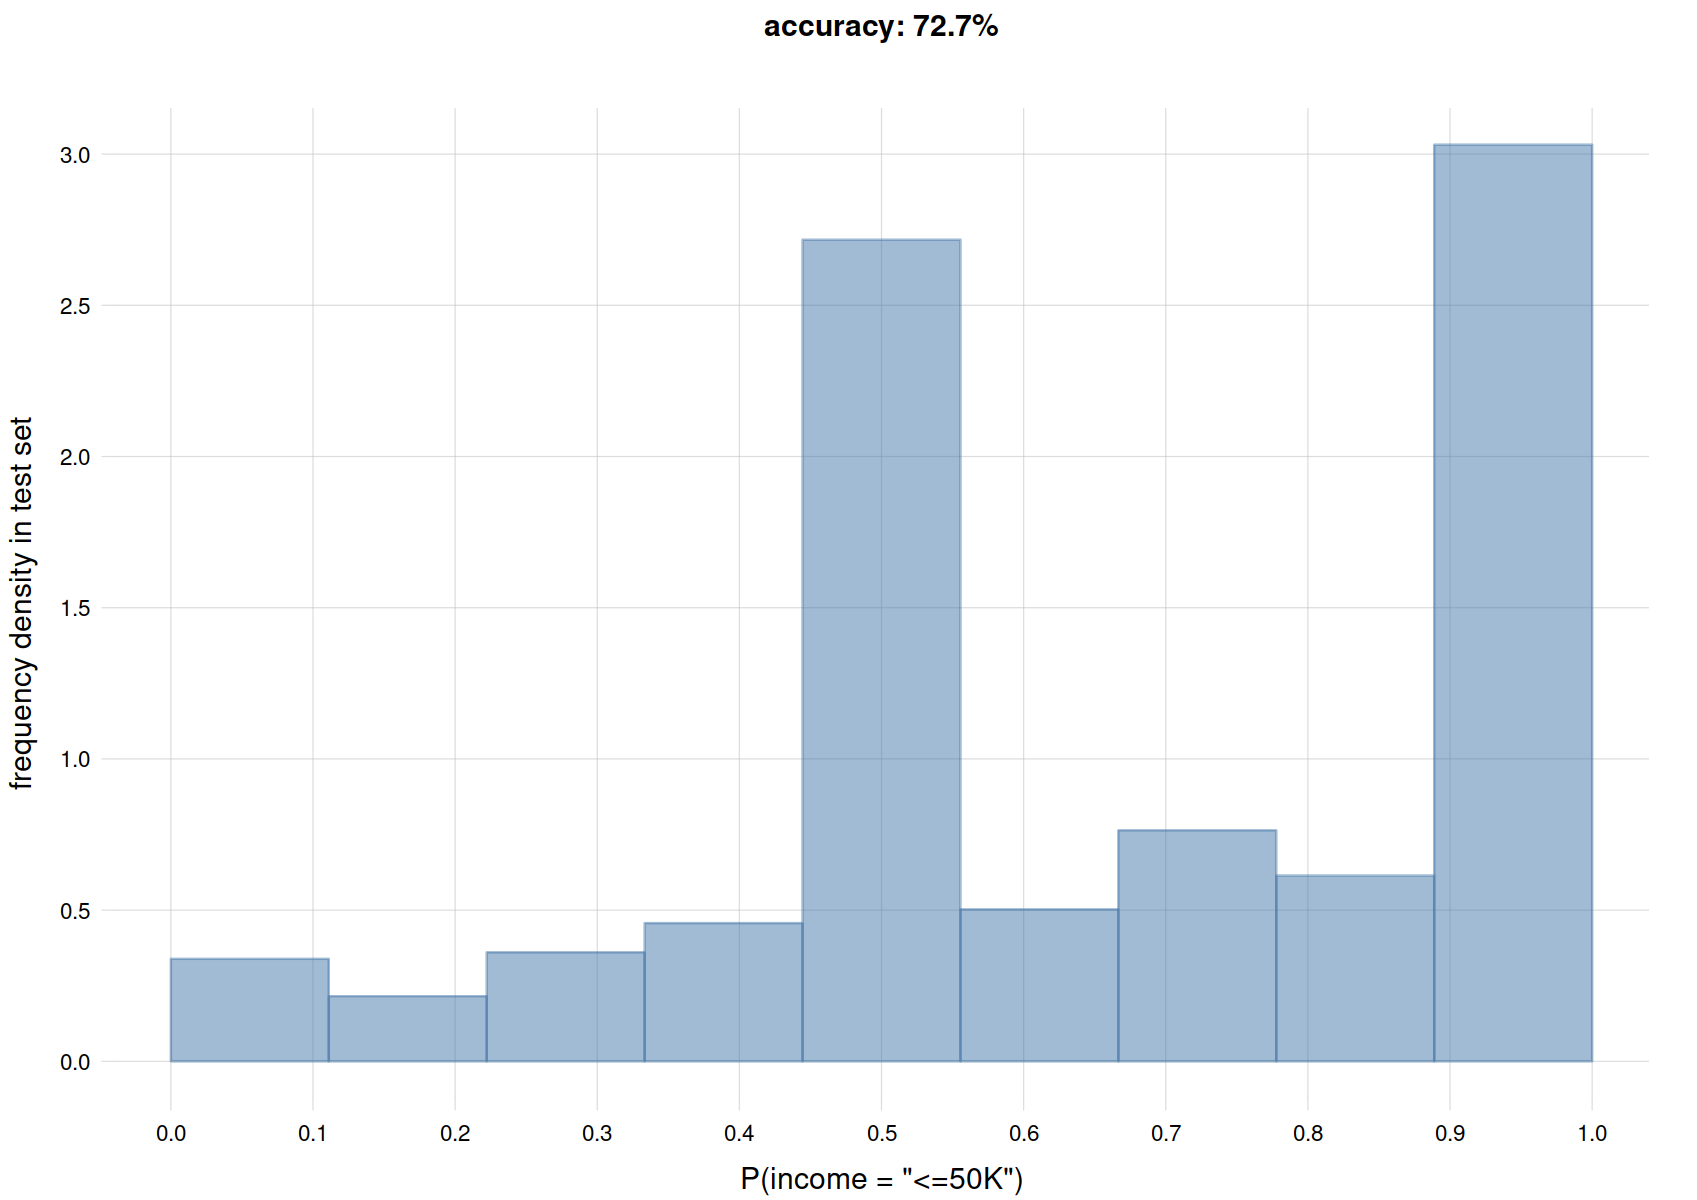

In [71]:
testdata <- fread('test-income_data_example.csv', header=TRUE) # read test data
ntest <- nrow(testdata) # number of test data

testprobs <- numeric(ntest) # prepare vector of probabilities
testhits <- numeric(ntest) # prepare vector of hits

stopwatch <- Sys.time() # record time

for(i in 1:ntest){
    ## calculate probabilities given all variates except 'income'
    probs <- infer(agent=opmall, predictor=testdata[i, !'income'])

    ## store the probability for <=50K
    testprobs[i] <- probs['<=50K']

    ## decide on one value, check if decision == true_value, and store result
    chosenvalue <- decide(probs=probs)

    testhits[i] <- (chosenvalue == testdata[i, 'income'])
}

print(Sys.time() - stopwatch) # print computation time


## Histogram and average
thist(testprobs, n=seq(0,1,length.out=10), plot=TRUE,
      xlab='P(income = "<=50K")',
      ylab='frequency density in test set',
      main=paste0('accuracy: ', round(100*mean(testhits), 1), '%'))